In [1]:
# k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr
# ! conda install -c conda-forge ta --yes

In [2]:
import websocket
import requests
import json
import pandas as pd
import ta
import matplotlib.pyplot as plt
import math
import datetime as dt
import numpy as np
import time

In [3]:
timezone = 8
endpoint = 'wss://stream.binance.com:9443/ws'
symbol = 'ethusdt'
symbol_C = symbol.upper()
interval = '1h'

# start epoch till now
start_time = 1672570703000
end_time = round(time.time() * 1000)
# end_time = 1672556207000

# step between timestamps in milliseconds
step = 60000 * 3600

In [4]:
def get_historical(symbol, interval, start_time, end_time, step):
    
    rawdf = pd.DataFrame()
    
    url = "https://api.binance.com/api/v3/klines"
    
    for timestamp in range(start_time, end_time, step):
        params = {"symbol": symbol_C,
                  "interval": interval,
                  "startTime": timestamp,
                  "endTime": timestamp + step}
        response = requests.get(url, params=params).json()
        out = pd.DataFrame(response, columns = ["Open time", "Open", "High", "Low", "Close",
                                               "Volume", "Close_Time", "Quote asset volume",
                                               "Number of trades", "Taker buy base asset volume",
                                               "Taker buy quote asset volume", "Ignore"])
        rawdf = pd.concat([rawdf, out], axis = 0)
    
    rawdf = rawdf[['Close_Time', 'Open', 'Close', "High", "Low", 'Volume']]
    convert_dict = {'Close_Time': float, 'Open': float, 'Close': float, "High": float, "Low": float, 'Volume': float}
    rawdf = rawdf.astype(convert_dict)
    
    rawdf['Close_Time'] = pd.to_datetime(rawdf['Close_Time'], unit = 'ms')
    rawdf['Close_Time'] = rawdf['Close_Time'] + pd.Timedelta(hours=timezone)
    rawdf['Close_Time'] = rawdf['Close_Time'].dt.strftime('%Y-%m-%d %H:%M:%S')
    
    rawdf = rawdf.reset_index(drop=True)
    
    return rawdf

In [5]:
rawdf = get_historical(symbol, interval, start_time, end_time, step)
print(rawdf)

               Close_Time     Open    Close     High      Low      Volume
0     2023-01-01 19:59:59  1197.14  1196.34  1197.41  1195.72   2854.0542
1     2023-01-01 20:59:59  1196.35  1197.17  1198.50  1195.83   4418.7365
2     2023-01-01 21:59:59  1197.16  1195.26  1197.29  1193.54   4804.4490
3     2023-01-01 22:59:59  1195.26  1194.50  1195.86  1194.20   3496.2584
4     2023-01-01 23:59:59  1194.50  1196.81  1196.81  1194.34   2771.4134
...                   ...      ...      ...      ...      ...         ...
1965  2023-03-24 16:59:59  1815.18  1794.88  1816.61  1787.74  32760.2611
1966  2023-03-24 17:59:59  1794.89  1786.82  1799.94  1782.10  32335.1088
1967  2023-03-24 18:59:59  1786.82  1787.47  1788.97  1776.78  25267.1882
1968  2023-03-24 19:59:59  1787.47  1789.52  1789.84  1783.11   6266.9460
1969  2023-03-24 20:59:59  1789.52  1789.52  1789.52  1789.52      0.0000

[1970 rows x 6 columns]


In [6]:
df = rawdf.copy()

In [7]:
def indicators(df):

# ema
    for i in (8, 14, 50):
        df['ema_'+str(i)] = ta.trend.ema_indicator(df.Close, window=i)

# atr
    df['atr'] = ta.volatility.average_true_range(df.High, df.Low, df.Close)

# kd
    kd_int = 14
    d_int = 3
   
    kddf = pd.DataFrame()
    kddf[str(kd_int) + '-Low'] = df['Low'].rolling(kd_int).min()
    kddf[str(kd_int) + '-High'] = df['High'].rolling(kd_int).max()
    df['slow_k'] = (df['Close'] - kddf[str(kd_int) + '-Low'])*100/(kddf[str(kd_int) + '-High'] - kddf[str(kd_int) + '-Low'])
    df['slow_d'] = df['slow_k'].rolling(d_int).mean()
    
    return df

def checkcross(df):
    series = df['slow_k'] < df['slow_d']
    return series.diff() & series

In [8]:
indicators(df)
df['kd_cross'] = checkcross(df)
print(df)

               Close_Time     Open    Close     High      Low      Volume  \
0     2023-01-01 19:59:59  1197.14  1196.34  1197.41  1195.72   2854.0542   
1     2023-01-01 20:59:59  1196.35  1197.17  1198.50  1195.83   4418.7365   
2     2023-01-01 21:59:59  1197.16  1195.26  1197.29  1193.54   4804.4490   
3     2023-01-01 22:59:59  1195.26  1194.50  1195.86  1194.20   3496.2584   
4     2023-01-01 23:59:59  1194.50  1196.81  1196.81  1194.34   2771.4134   
...                   ...      ...      ...      ...      ...         ...   
1965  2023-03-24 16:59:59  1815.18  1794.88  1816.61  1787.74  32760.2611   
1966  2023-03-24 17:59:59  1794.89  1786.82  1799.94  1782.10  32335.1088   
1967  2023-03-24 18:59:59  1786.82  1787.47  1788.97  1776.78  25267.1882   
1968  2023-03-24 19:59:59  1787.47  1789.52  1789.84  1783.11   6266.9460   
1969  2023-03-24 20:59:59  1789.52  1789.52  1789.52  1789.52      0.0000   

            ema_8       ema_14       ema_50        atr     slow_k     slow_

In [9]:
def conditions(df):
    # k crossover d，close > ema 8, ema 8 > ema 14, ema 14 > 50, take profit 2 atr, stop loss 3 atr

    for index, row in df.iterrows():
        # c1
        df['c1'] = df['kd_cross']
        # c2
        df['c2'] = df['Close'] <= df['ema_8']
        # c3
        df['c3'] = df['ema_8'] <= df['ema_14']
        # c4
        df['c4'] = df['ema_14'] <= df['ema_50']

    # 條件達成
    df['signal'] = False
    df.loc[df.c1 & df.c2 & df.c3 & df.c4, 'signal'] = True


    # 下一根進場
    df['open_short'] = False
    for i in range(len(df) - 1):
        if df.loc[i, 'signal'] == True:
            df.loc[i + 1, 'open_short'] = True
#     print(df[df['Close_Time'].str.contains('2023-03-11 16')])
    
    return df

In [10]:
conditions(df)

,Close_Time,Open,Close,High,Low,Volume,ema_8,ema_14,ema_50,atr,slow_k,slow_d,kd_cross,c1,c2,c3,c4,signal,open_short
0,2023-01-01 19:59:59,1197.14,1196.34,1197.41,1195.72,2854.0542,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
1,2023-01-01 20:59:59,1196.35,1197.17,1198.50,1195.83,4418.7365,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
2,2023-01-01 21:59:59,1197.16,1195.26,1197.29,1193.54,4804.4490,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
3,2023-01-01 22:59:59,1195.26,1194.50,1195.86,1194.20,3496.2584,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
4,2023-01-01 23:59:59,1194.50,1196.81,1196.81,1194.34,2771.4134,NaN,NaN,NaN,0.000000,NaN,NaN,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1965,2023-03-24 16:59:59,1815.18,1794.88,1816.61,1787.74,32760.2611,1807.987240,1806.265862,1789.118414,15.666802,19.844358,44.242854,True,True,True,False,False,False,False
1966,2023-03-24 17:59:59,1794.89,1786.82,1799.94,1782.10,32335.1088,1803.283409,1803.673081,1789.028280,15.822030,12.099462,30.900654,False,False,True,True,False,False,False
1967,2023-03-24 18:59:59,1786.82,1787.47,1788.97,1776.78,25267.1882,1799.769318,1801.512670,1788.967171,15.562599,24.114595,18.686138,False,False,True,True,False,False,False
1968,2023-03-24 19:59:59,1787.47,1789.52,1789.84,1783.11,6266.9460,1797.491692,1799.913647,1788.988851,14.931699,28.739003,21.651020,False,False,True,True,False,False,False


In [11]:
entry_df = conditions(df)

# 進出場

in_position = False
stop_loss = np.nan
close_val = entry_df['Close']
atr_val = entry_df['atr']


for index, row in entry_df.iterrows():

    if index == 0:
        continue
    
    elif entry_df.at[index, 'open_short'] == True:
   
        entry_df.at[index, 'entry_p'] = close_val.shift(1).at[index]
        entry_df.at[index, 'stop_loss'] = close_val.shift(1).at[index] + 3 * atr_val.shift(1).at[index]
        entry_df.at[index, 'take_profit'] = close_val.shift(1).at[index] - 3.5 * atr_val.shift(1).at[index]
        entry_df.at[index, 'position'] = 'Short'
        entry_df.at[index, 'status'] = 'Pending'
        in_position = True
        stop_loss = entry_df.at[index, 'stop_loss']
    
for index, row in entry_df.iterrows():
    # Check if the jth row's status is 'Pending'
    if entry_df.loc[index, 'status'] == 'Pending':
        for j in range(index, len(entry_df)):
            if entry_df.loc[j, 'Low'] <= entry_df.loc[index, 'take_profit']:
                profit = -(entry_df.loc[index, 'take_profit'] - entry_df.loc[index, 'entry_p'])
                entry_df.loc[index, 'status'] = 'Close_Short'
                entry_df.loc[index, 'profit'] = profit
                break

            if entry_df.loc[j, 'Close'] >= entry_df.loc[index, 'stop_loss']:
                profit = -(entry_df.loc[index, 'stop_loss'] - entry_df.loc[index, 'entry_p'])
                entry_df.loc[index, 'status'] = 'Stop'
                entry_df.loc[index, 'profit'] = profit
                break
        
for index, row in entry_df.iterrows():

    if entry_df.loc[index, 'status'] == 'Pending':
        entry_df.loc[index, 'profit'] = 0

entry_df.to_csv('entry_df.csv')

raw_entry_df = entry_df.copy()

# 過濾有訊號或事件發生的Ｋ線
entry_df = entry_df[(entry_df['open_short'] == True) |
              (entry_df['signal'] == True) | 
              (entry_df['position'] == 'Short') |
              (entry_df['position'] == 'Close_Short') |
              (entry_df['position'] == 'Stop')]


print(entry_df)


               Close_Time     Open    Close     High      Low      Volume  \
417   2023-01-19 04:59:59  1541.96  1521.38  1544.78  1516.55  30763.2242   
418   2023-01-19 05:59:59  1521.38  1528.46  1532.46  1519.62  13064.2538   
420   2023-01-19 07:59:59  1531.39  1511.43  1533.28  1507.90  21837.7252   
421   2023-01-19 08:59:59  1511.44  1516.26  1523.25  1509.15  18982.5522   
432   2023-01-19 19:59:59  1525.27  1519.61  1525.37  1516.17  12086.7352   
...                   ...      ...      ...      ...      ...         ...   
1931  2023-03-23 06:59:59  1719.47  1726.72  1728.23  1713.46  26215.9458   
1934  2023-03-23 09:59:59  1737.37  1730.06  1737.56  1729.54  15049.0178   
1935  2023-03-23 10:59:59  1730.06  1739.07  1740.11  1729.35  11799.4886   
1937  2023-03-23 12:59:59  1737.22  1731.70  1739.33  1730.17  20771.2629   
1938  2023-03-23 13:59:59  1731.69  1749.27  1752.22  1730.44  23286.5427   

            ema_8       ema_14       ema_50        atr  ...    c3    c4  \


In [12]:
# 部位回測

posdf = entry_df.copy()
posdf = posdf.reset_index(drop = True)
posdf = posdf[(posdf['position'] == 'Short')]


col = ['Close_Time', 'Open', 'Close', 'High', 'Low', 'atr', 'position', 'entry_p', 'stop_loss', 'take_profit', 'status', 'profit']
pos = posdf[col]
pos = pos.reset_index(drop = True)

        
print(pos)
pos.to_csv('pos.csv')


# 手續費、滑點、價差
fee = 0.03 / 100
entry_amt = pos.entry_p.sum()
SL_amt = pos.loc[pos.status == 'Stop', 'stop_loss'].sum()
TP_amt = pos.loc[pos.status == 'Close_Short', 'take_profit'].sum()
ttl_fee = (entry_amt + SL_amt + TP_amt) * fee

# 損益
leverage = 10
ttl_profit = pos.profit.sum() - ttl_fee

wins = pos['status'].str.count('Close_Short').sum()
loses = pos['status'].str.count('Stop').sum()
win_rate = "{:.2f}%".format(wins / (wins + loses) * 100)

result = {'Profit': [round(ttl_profit, 2)],
          'Fee': [round(ttl_fee, 2)],
          'Win_Rate': [win_rate]}


result_df = pd.DataFrame(result)

print(result_df)



             Close_Time     Open    Close     High      Low        atr  \
0   2023-01-19 05:59:59  1521.38  1528.46  1532.46  1519.62  19.365165   
1   2023-01-19 08:59:59  1511.44  1516.26  1523.25  1509.15  19.074835   
2   2023-01-19 20:59:59  1519.60  1519.19  1523.11  1513.33  12.317084   
3   2023-01-24 04:59:59  1619.89  1634.80  1635.26  1618.65  16.221746   
4   2023-01-24 07:59:59  1627.47  1626.29  1630.48  1624.72  14.670520   
..                  ...      ...      ...      ...      ...        ...   
89  2023-03-21 11:59:59  1748.74  1746.14  1752.31  1743.03  18.314288   
90  2023-03-21 14:59:59  1740.44  1738.83  1746.45  1733.99  17.017791   
91  2023-03-23 06:59:59  1719.47  1726.72  1728.23  1713.46  21.846242   
92  2023-03-23 10:59:59  1730.06  1739.07  1740.11  1729.35  19.091019   
93  2023-03-23 13:59:59  1731.69  1749.27  1752.22  1730.44  17.827376   

   position  entry_p    stop_loss  take_profit       status     profit  
0     Short  1521.38  1580.981301  145

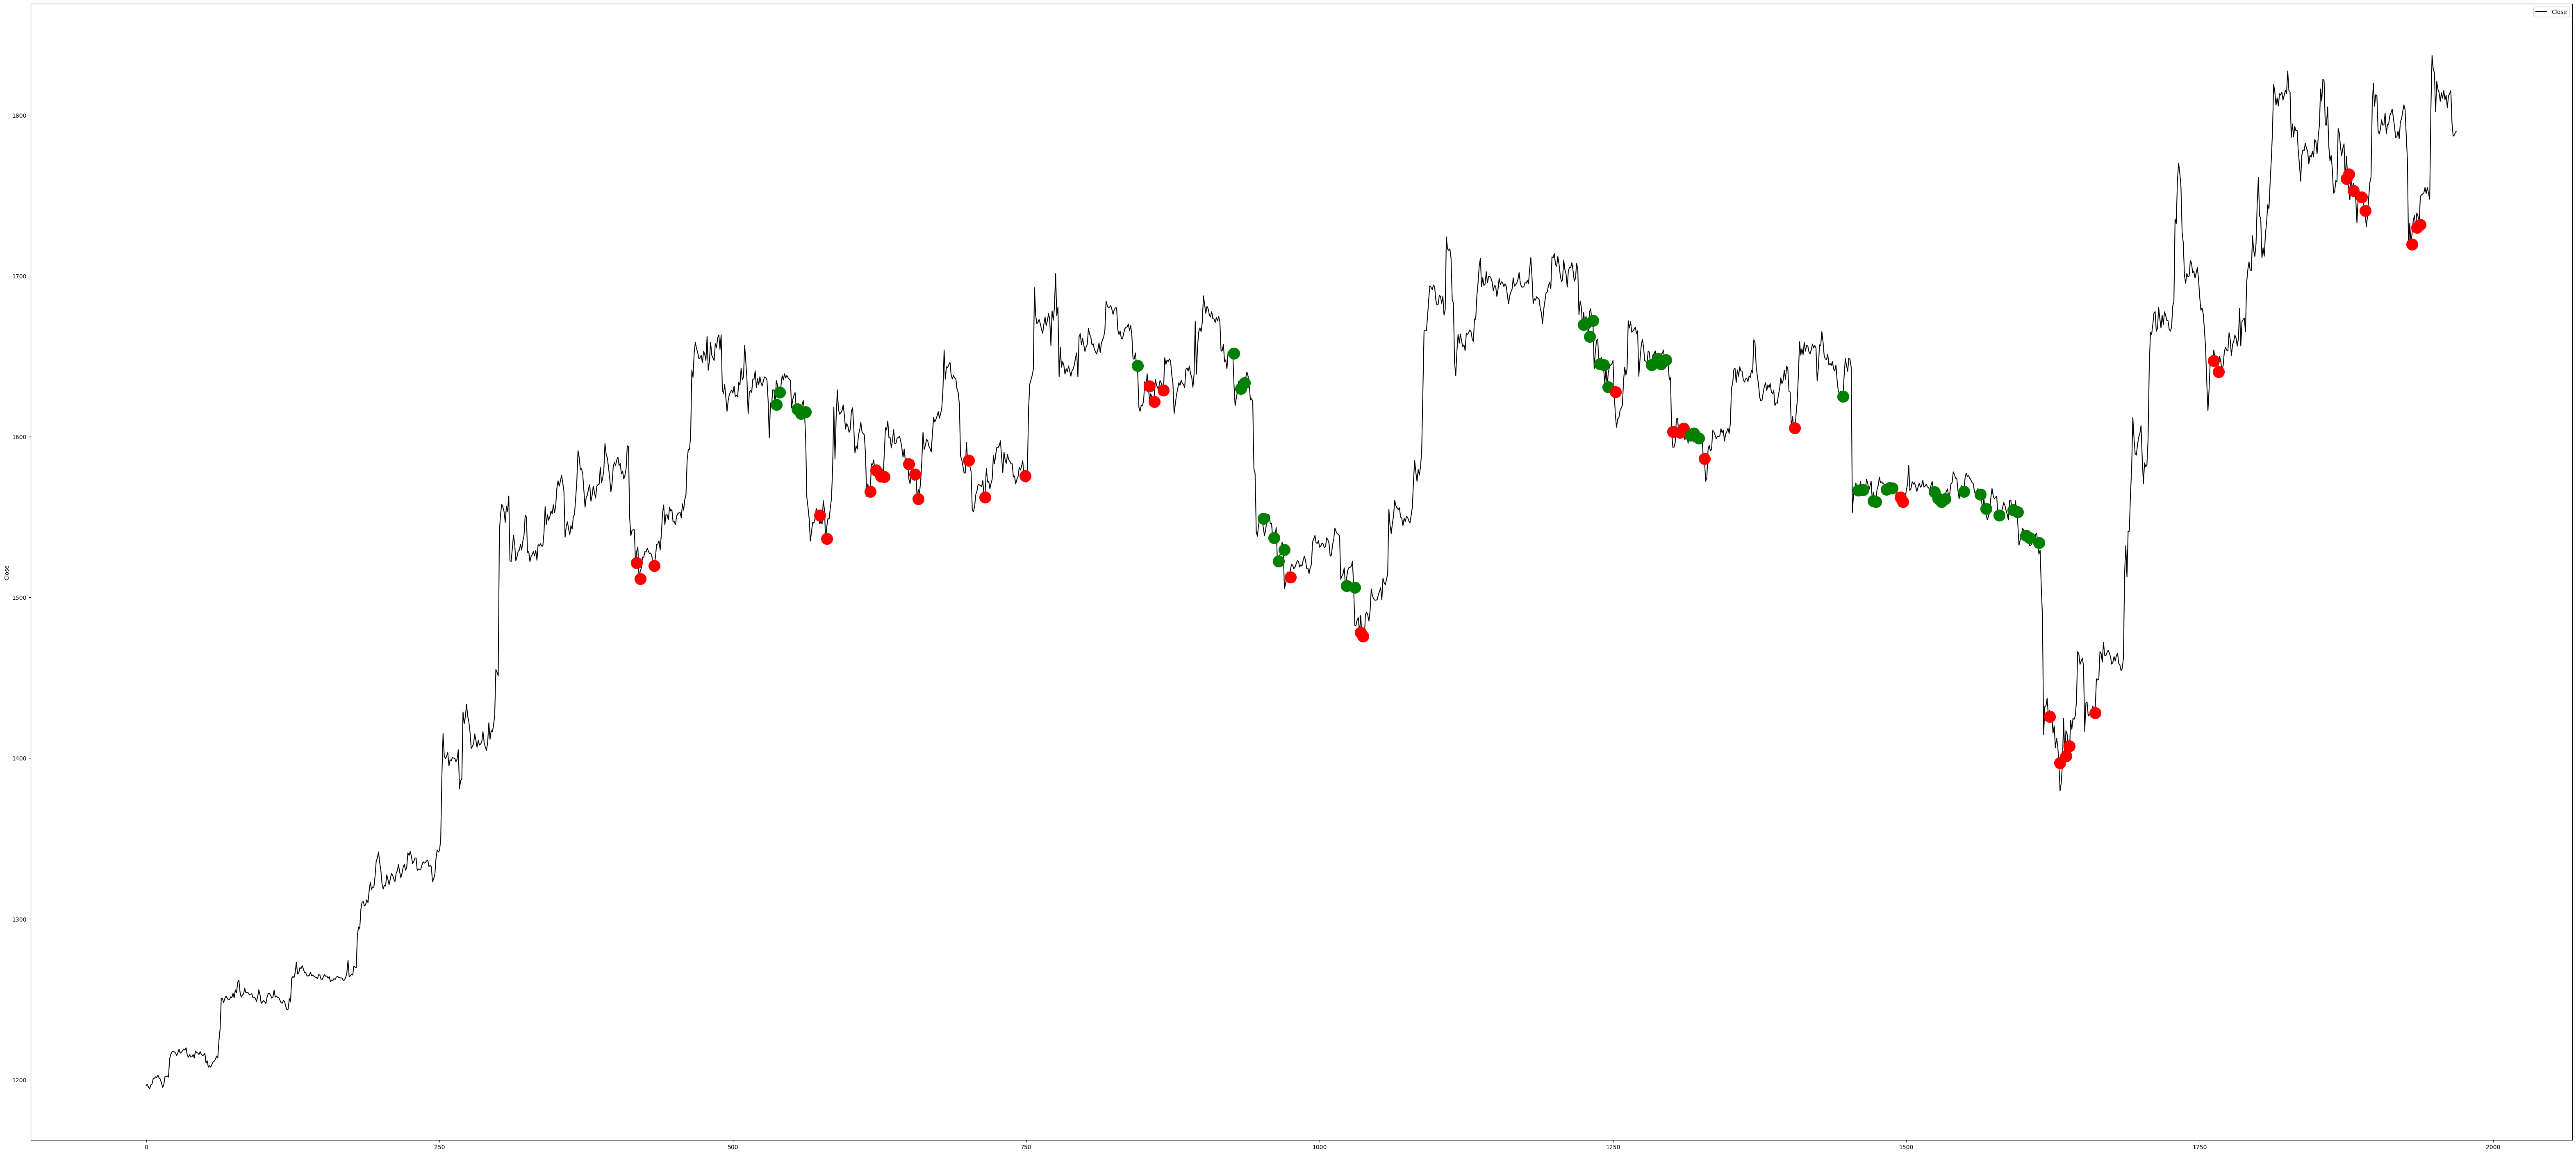

In [13]:
plt_df = raw_entry_df.copy()

plt.figure(figsize=(80, 36))
plt.ylabel('Close')
plt.plot(plt_df.Close, label = 'Close', c ='black')
for i in range(len(plt_df)):
    if plt_df.status[i] == 'Close_Short':
        plt.plot(i, plt_df.entry_p[i], 'go', label='_', markersize=20)
    elif plt_df.status[i] == 'Stop':
        plt.plot(i, plt_df.entry_p[i], 'ro', label='_', markersize=20)
# plt.plot(plt_df.ema_8, label='ema_8', c='g', lw=0.5)
# plt.plot(plt_df.ema_14, label='ema_14', c='r', lw=0.5)
# plt.plot(plt_df.ema_50, label='ema_50', c='b', lw=0.5)
# plt.plot(plt_df.ema_200, label='ema_200', c='y', lw=4)
plt.legend()
plt.show()